Here we use a simple case study, generate ODE using symbolic maniupulation (`sympy`) and translate that to `jax`. 
Then we use `Diffrax` to solve the ODEs. 
Finally we use `optax` to optimize the model parameters to data

dependencies:

In [323]:
#!pip install optax

In [1]:
# basics
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# symbolic computation:
import sympy as sym
from sympy2jax import sympy2jax

# jax: 
import jax
import jax.numpy as jnp
from jax import random as jxrandom
import jax.numpy as jnp

# ODE solution Diffrax: 
from diffrax import diffeqsolve, ODETerm, Dopri5, SaveAt
import diffrax

# optimization:
import optax

definition of the ToyMSB model using `sympy`  
TODOs:
- vectorize (state-vector, parameter vector etc)
- generate the equations from the reaction graph
- extend the AND and OR gates to multiple inputs


In [2]:
# States
TGFa = sym.symbols("TGFa")
TNFa = sym.symbols("TNFa")
PI3K = sym.symbols("PI3K")
Raf = sym.symbols("Raf")
NFkB = sym.symbols("NFkB")
AKT = sym.symbols("AKT")
C8 = sym.symbols("C8")
ERK = sym.symbols("ERK")

# Tau - one for each state
t_TGFa = sym.symbols("t_TGFa")
t_TNFa = sym.symbols("t_TNFa")
t_PI3K = sym.symbols("t_PI3K")
t_Raf = sym.symbols("t_Raf")
t_NFkB = sym.symbols("t_NFkB")
t_AKT = sym.symbols("t_AKT")
t_C8 = sym.symbols("t_C8")
t_ERK = sym.symbols("t_ERK")

# n and k for each edge
TGFa_k_PI3K = sym.symbols("TGFa_k_PI3K")
TGFa_k_Raf = sym.symbols("TGFa_k_Raf")
TNFa_k_NFkB = sym.symbols("TNFa_k_NFkB")
TNFa_k_C8 = sym.symbols("TNFa_k_C8")
PI3K_k_AKT = sym.symbols("PI3K_k_AKT")
PI3K_k_NFkB = sym.symbols("PI3K_k_NFkB")
Raf_k_ERK = sym.symbols("Raf_k_ERK")
NFkB_k_ERK = sym.symbols("NFkB_k_ERK")

TGFa_n_PI3K = sym.symbols("TGFa_n_PI3K")
TGFa_n_Raf = sym.symbols("TGFa_n_Raf")
TNFa_n_NFkB = sym.symbols("TNFa_n_NFkB")
TNFa_n_C8 = sym.symbols("TNFa_n_C8")
PI3K_n_AKT = sym.symbols("PI3K_n_AKT")
PI3K_n_NFkB = sym.symbols("PI3K_n_NFkB")
Raf_n_ERK = sym.symbols("Raf_n_ERK")
NFkB_n_ERK = sym.symbols("NFkB_n_ERK")

# state names: 
sym_states = [TGFa, TNFa, PI3K, Raf, NFkB,AKT,C8,ERK]
state_names = ["TGFa", "TNFa", "PI3K", "Raf", "NFkB","AKT","C8","ERK"]
# parameter names: tau, n and k parameters
parameter_names = [["t_TGFa", "t_TNFa", "t_PI3K", "t_Raf", "t_NFkB","t_AKT","t_C8","t_ERK"],
                    ["TGFa_n_PI3K", "TGFa_n_Raf", "TNFa_n_NFkB", "TNFa_n_C8","PI3K_n_AKT","PI3K_n_NFkB","Raf_n_ERK","NFkB_n_ERK"],
                    ["TGFa_k_PI3K", "TGFa_k_Raf", "TNFa_k_NFkB", "TNFa_k_C8","PI3K_k_AKT","PI3K_k_NFkB","Raf_k_ERK","NFkB_k_ERK"]]

sym_parmeters =  [t_TGFa, t_TNFa, t_PI3K, t_Raf, t_NFkB,t_AKT,t_C8,t_ERK,
                    TGFa_n_PI3K, TGFa_n_Raf, TNFa_n_NFkB, TNFa_n_C8,PI3K_n_AKT,PI3K_n_NFkB,Raf_n_ERK,NFkB_n_ERK,
                    TGFa_k_PI3K, TGFa_k_Raf, TNFa_k_NFkB, TNFa_k_C8,PI3K_k_AKT,PI3K_k_NFkB,Raf_k_ERK,NFkB_k_ERK]   

#Experiment design:
inhibitors = pd.DataFrame(
    {
        'PI3K': [0, 0, 0, 1, 1, 0],
        'Raf': [0, 0, 0, 0, 0, 1]
    }, 
    index = [f"experiment_{i}" for i in range(6)])
    
# normalised Hill equations (for each reactions) ( x^n / (k^n + x^n) * {1/(1/k^n + 1)} )
def norm_hill_fun(parental_var,n,k):
    return parental_var**n / (k**n + parental_var**n) * (k**n + 1)

def ORgate(x,y):
    return x+y-x*y 
    
def ANDgate(x,y):
    return x*y 

def get_sym_right_hand_side(iEXP = 0):
    # right hand sides
    f_TGFa = 0
    f_TNFa = 0

    if inhibitors["PI3K"][iEXP] == 1:
        f_PI3K = PI3K - PI3K  # 0, but symbolic:D
    else:
        f_PI3K = t_PI3K*(norm_hill_fun(TGFa,TGFa_n_PI3K,TGFa_k_PI3K) - PI3K)

    if inhibitors["Raf"][iEXP] == 1:
        f_Raf = Raf - Raf
    else:
        f_Raf = t_Raf*(norm_hill_fun(TGFa,TGFa_n_Raf,TGFa_k_Raf) - Raf)

    f_NFkB = t_NFkB*(ORgate(norm_hill_fun(PI3K,PI3K_n_NFkB,PI3K_k_NFkB),norm_hill_fun(TNFa,TNFa_n_NFkB,TNFa_k_NFkB)) - NFkB )
        
    f_AKT = t_AKT*(1-norm_hill_fun(PI3K,PI3K_n_AKT,PI3K_k_AKT) - AKT)
    f_C8 = t_C8 * (norm_hill_fun(TNFa,TNFa_n_C8,TNFa_k_C8) - C8)
    f_ERK = t_ERK * (ANDgate(norm_hill_fun(Raf,Raf_n_ERK,Raf_k_ERK),norm_hill_fun(NFkB,NFkB_n_ERK,NFkB_k_ERK)) - ERK)

    return [f_TGFa,f_TNFa,f_PI3K,f_Raf,f_NFkB,f_AKT,f_C8,f_ERK]

iexp =0

# get the symbolic equation of the ODE's right hand side
f_sym = get_sym_right_hand_side(iEXP=iexp)

Numerical parameter values

In [3]:
# generate random numbers for the different types of parameters

def generate_random_parameters(key,par_names):
    key_tau, key_k, key_n  = jax.random.split(key,3)
    tau_parameter_value = jax.random.uniform(key_tau,shape=(len(par_names[0]),),minval=1e-5,maxval=1)
    k_parameter_value = jax.random.uniform(key_k,shape=(len(par_names[1]),),minval=0.5,maxval=5)
    n_parameter_value = jax.random.uniform(key_n,shape=(len(par_names[2]),),minval=1,maxval=3)

    parameter_values = jnp.concatenate((tau_parameter_value,n_parameter_value,k_parameter_value))
    return(parameter_values)

par_key = jax.random.PRNGKey(1246)
parameter_values =  generate_random_parameters(key=par_key,par_names=parameter_names)

Convert the symbolic ODEs to `jax` expressions

In [4]:
all_syms = [*sym_states, *sym_parmeters]

# vectorized version of sympy2jax. Converts the list of equations into a list of `jax` and `param` objects
def symODEs2jax(f_sym):

    # Construct a list of jax functions. 
    f_jax = list()
    f_jax_params = list()
    for i_f_sym in f_sym:
        if i_f_sym==0:
            f_jax.append(0)
            f_jax_params.append(0)
        else:
            f, params = sympy2jax(i_f_sym, all_syms)
            f_jax.append(f)
            f_jax_params.append(params)
    return   f_jax, f_jax_params

f_jax, f_jax_params = symODEs2jax(f_sym)

Formulate the ODE function that takes the state vector (`y`), time (`t`) and users' data (`args`) and returns the evaluation of the right hand side


In [5]:
def jaxODE2numeric(t, y, args):

    # get users data containinf the jax objects and model parameters: 
    f_jax = args["jax_eqns"]
    f_jax_p = args["jax_parameters"]
    parameter_vals = args["model_parameters"]

    jax_pars = [*y,*parameter_vals]
    fy = list()

    for i in range(len(y)):
        if f_jax[i] == 0:
            fy.append(jnp.array([0.0,])[0])
        else:
            fy.append(f_jax[i](jnp.array([jax_pars,]),f_jax_p[1])[0])
    return jnp.asarray(fy)

Solve the ODE using `diffrax`

In [6]:
model_data = {"jax_eqns" : f_jax,
         "jax_parameters": f_jax_params,
         "model_parameters": parameter_values}

def simulate_model(model_data, ts = jnp.linspace(0, 10, 100), y0= jnp.array([1., 1., 0., 0., 0., 0., 0., 0.])):

    
    term = ODETerm(jaxODE2numeric)

    # ODE solvers based on the recommendation from  https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/
    # 
    # Non-stiff solver:
    # diffrax.Heun - low accuracy, but could be useful for neural ODEs
    # diffrax.Tsit5 - good general purpose solver, slightly better than Dopri5
    # 
    # Stiff solver: 
    # Kvaerno3, Kvaerno4, Kvaerno5  
    # use adaptive step size controller PIDController

    solver = diffrax.Heun()
    solution = diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.1, y0=y0, args = model_data, 
                saveat=SaveAt(ts=ts),stepsize_controller = diffrax.PIDController(atol=1e-3,rtol=1e-3))

    return solution.ts, solution.ys

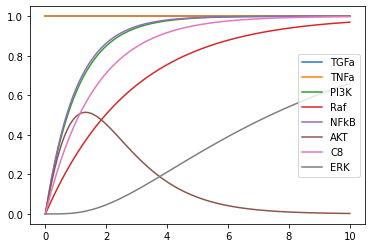

In [7]:
sol_ts, sol_ys = simulate_model(model_data)

def plot_simulation(ts,ys,names):

    for istate in range(len(names)):
        plt.plot(ts, ys[:, istate],label=names[istate])
    plt.legend()
    plt.show()
plot_simulation(sol_ts,sol_ys,state_names)

## Model optimization

generate training data

In [8]:
def get_simulated_data(N_ts, key, model_data, noise_sd):

    ts = jnp.linspace(0, 10, N_ts)
    sol_ts, sol_ys = simulate_model(model_data, ts = jnp.linspace(0, 10, N_ts))

    ys = sol_ys
    ys += noise_sd*jxrandom.normal(key,(ys.shape[0],ys.shape[1]))
    ys = abs(ys)
    return sol_ts, ys

In [9]:
# random key to generate the ground truth data: 
key_GT = jax.random.PRNGKey(5678)
par_key, noise_key = jxrandom.split(key_GT,2)

# parameter values in the GT model:
GT_parameter_values =  generate_random_parameters(key=par_key,par_names=parameter_names)
gt_model = model_data
gt_model['model_parameters'] = GT_parameter_values

#Exp design: take 5 samples across time: 
N_samples = 5

training_data = get_simulated_data(N_samples, key=noise_key, model_data = gt_model, noise_sd=0.05)
training_data_no_noise = get_simulated_data(N_samples, key=noise_key, model_data = gt_model, noise_sd=0)

plotting training data

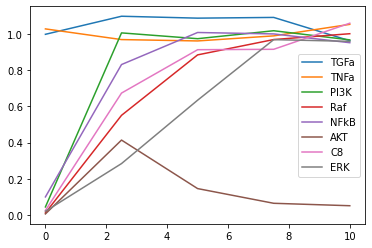

In [10]:
plot_simulation( ts=training_data[0],ys=training_data[1],names=state_names)

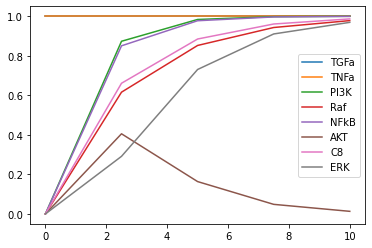

In [11]:
plot_simulation( ts=training_data_no_noise[0],ys=training_data_no_noise[1],names=state_names)

In [12]:
# mean squared error calculation. Copied from Pablo. Not sure if we need nan or if it is correctly handled for ODEs. 
# FIXME handle cases when nans are in the data or simulation

def loss_mse(X,X_hat):
    # Count the number of valid values in the matrix
    is_nan = jnp.isnan(X)
    n = jnp.sum(~is_nan)
    # Replace NaNs with 0s. It does not affect the loss
    # as we're going to compute the average ignoring 0s
    Xf = jnp.nan_to_num(X, nan=0.)
    # Put 0s on NaN positions
    X_hat_f = jnp.where(is_nan, 0., X_hat)
    # Sum of squared residuals
    sq = jnp.power(Xf - X_hat_f, 2)
    # Average using non missing entries
    return jnp.sum(sq) / n


loss_mse(training_data[1],training_data_no_noise[1])

DeviceArray(0.00245088, dtype=float32)

In [13]:
working_model_data = model_data.copy()

# Loss function called by the optimizer. 
# simulates the model and returns the objective function value. 
def loss(params:optax.Params, y:jnp.ndarray) -> jnp.ndarray:
    working_model_data["model_parameters"] = params
    
    _, y_hat = simulate_model(ts=jnp.linspace(0, 10, N_samples), model_data=working_model_data)
    #print(y_hat)
    return loss_mse(y,y_hat)


In [14]:
# test: ground truth parameter vs noise-free training data: 
print(loss(GT_parameter_values,training_data_no_noise[1]))

# test 2: ground truth parameters vs noisy data
print(loss(GT_parameter_values,training_data[1]))

# test 3: perturbed parameters vs noise free data
perturbed_pars = GT_parameter_values + 0.1*jxrandom.normal(jax.random.PRNGKey(1),(GT_parameter_values.shape[0],))
print(loss(perturbed_pars,training_data_no_noise[1]))

0.0
0.002450878
0.00275029


In [15]:
# Initial parameters for the optimization. 
# Make sure it is different from the ground truth :) 
# Also make sure the initial cost is worse than the simulation with the ground truth parameter vector

key_optim_init_par = jax.random.PRNGKey(197)
initial_params =  generate_random_parameters(key=key_optim_init_par,par_names=parameter_names)
print("difference from the ground truth parameters:")
print(initial_params - GT_parameter_values)
print("loss with the initial parameters:")
print("\t" + str(loss(initial_params,training_data[1])))
print("loss with the ground truth parameters:")
print("\t" + str(loss(GT_parameter_values,training_data[1])))

difference from the ground truth parameters:
[-2.6584238e-01 -5.0790966e-02 -5.0273609e-01 -1.5214792e-01
  1.3970900e-01  2.6006770e-01 -4.1763210e-01 -4.8793173e-01
  3.1356645e-01 -5.3030014e-01  1.4325817e+00  5.0519371e-01
 -9.8922467e-01  2.6668882e-01  1.3079793e+00 -1.3101101e-03
 -2.0347238e-01 -1.5911324e+00  9.7999072e-01 -3.1753933e+00
 -1.1988883e+00 -6.4866185e-01  1.2459474e+00 -2.0891743e+00]
loss with the initial parameters:
	0.089982614
loss with the ground truth parameters:
	0.002450878


Compute the finite difference based grad of the loss function to see if jax returns the correct value

In [16]:
loss(initial_params,training_data[1])
ref = initial_params.copy()
loss(ref,training_data[1])


DeviceArray(0.08998261, dtype=float32)

In [17]:
# computes the gradient by central finite difference
# evaluates the loss function at p and measured_data
def cfd_grad_loss(p,measured_data,dp=0.01):
    
    ref = p.copy()

    grad = np.zeros((len(p),))

    for i in range(len(p)):
        p_working_p = np.array(ref)
        p_working_n = np.array(ref)
        p_working_p[i] += dp/2
        p_working_n[i] -= dp/2
        forward = loss(jnp.array(p_working_p),measured_data)
        backward = loss(jnp.array(p_working_n),measured_data)
        grad[i] = (forward - backward) / (dp)
    return(grad)

cfd_grad_loss(initial_params,training_data[1])

array([ 0.00000000e+00,  0.00000000e+00, -5.29475510e-02, -1.54880434e-01,
       -7.89761543e-05, -4.40329313e-04, -9.34488356e-01, -2.16804445e-02,
       -1.49011612e-06,  1.49011612e-06,  0.00000000e+00,  0.00000000e+00,
        3.94135714e-03, -7.45058060e-07,  8.59797001e-03,  7.22706318e-05,
        7.45058060e-07,  7.45058060e-07, -7.45058060e-07,  0.00000000e+00,
        4.74601984e-04,  1.49011612e-06,  3.30805779e-04,  5.08874655e-04])

In [18]:
optimizer = optax.adam(learning_rate=1e-2) 
opt_state = optimizer.init(initial_params)
params = initial_params

loss_value, grads = jax.value_and_grad(loss)(params, training_data[1])


In [19]:
loss_value

DeviceArray(0.08998264, dtype=float32)

In [20]:
grads

DeviceArray([ 0.0000000e+00,  0.0000000e+00, -5.2929558e-02,
             -1.5482330e-01, -7.1480135e-05, -4.3470750e-04,
             -9.3349218e-01, -2.1679381e-02, -2.8467184e-10,
              2.9831426e-09, -3.9398174e-10,  7.6397555e-11,
              3.9425925e-03, -7.1305684e-11,  8.5970582e-03,
              7.2868002e-05, -2.4811015e-09,  2.1973392e-09,
             -1.2789769e-10,  2.1100277e-10,  4.7517344e-04,
             -4.5117785e-11,  3.3132813e-04,  5.0829642e-04],            dtype=float32)

In [21]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
  opt_state = optimizer.init(params)

  def step(params, opt_state, training_data_batch):
    loss_value, grads = jax.value_and_grad(loss)(params, training_data_batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for i in range(500):
    data  = training_data[1]
    params, opt_state, loss_value = step(params, opt_state, data)
    if i % 10 == 0:
      print(f'step {i}, loss: {loss_value}')

  return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=1e-2)
params = fit(initial_params, optimizer)

step 0, loss: 0.08998263627290726
step 10, loss: 0.028022151440382004
step 20, loss: 0.012836119160056114
step 30, loss: 0.00826035626232624
step 40, loss: 0.006450826767832041
step 50, loss: 0.0055086310021579266
step 60, loss: 0.004902943037450314
step 70, loss: 0.004460158292204142
step 80, loss: 0.0041143507696688175
step 90, loss: 0.003838446456938982
step 100, loss: 0.0036143746692687273
step 110, loss: 0.0034284249413758516
step 120, loss: 0.003271767171099782
step 130, loss: 0.0031384299509227276
step 140, loss: 0.003024174366146326
step 150, loss: 0.00292575778439641
step 160, loss: 0.0028406656347215176
step 170, loss: 0.0027668545953929424
step 180, loss: 0.002702620578929782
step 190, loss: 0.00264656450599432
step 200, loss: 0.002597569487988949
step 210, loss: 0.002554647158831358
step 220, loss: 0.0025169544387608767
step 230, loss: 0.0024837241508066654
step 240, loss: 0.0024543723557144403
step 250, loss: 0.002428351668640971
step 260, loss: 0.0024051994550973177
step 